In [1]:
import sys
sys.path.append("../src")
import preprocessing
import cconfig
import clustering
import utils
import pandas as pd

# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt

# Load data and preprocess

In [2]:
# select type of features and default values
#dataset_type=cconfig.DATASET_TYPE_FLOW
dataset_type=cconfig.DATASET_TYPE_BIFLOW
#selected_features=cconfig.SELECTED_FEATURES_UFLOW
selected_features=cconfig.SELECTED_FEATURES_BIFLOW
max_num_clusters=cconfig.DEFAULT_NUM_CLUSTERS
sort_anomalies=cconfig.BIFLOW_ANOMALIES_SORT
#sort_anomalies=cconfig.FLOW_ANOMALIES_SORT

# Load and transform data

In [3]:
# load original data in dataframes, sample, select some features and scale
df,df_Normal,df_Attack=preprocessing.data_load(1,None,False,dataset_type)
print(df.columns)
X=preprocessing.data_scale(df[selected_features])
X_Normal=preprocessing.data_scale(df_Normal[selected_features])
X_Attack=preprocessing.data_scale(df_Attack[selected_features])

Index(['tcp_stream', 'protocol', 'flow_id', 'flow_start', 'flow_finish',
       'src_ip', 'src_port', 'dst_ip', 'dst_port', 'total_duration',
       'start_time', 'finish_time', 'total_packets', 'total_bytes', 'pps',
       'bps', 'bpp', 'total_http_errors', 'total_failures', 'flag_ack',
       'flag_fin', 'flag_psh', 'flag_rst', 'flag_syn', 'first_flag',
       'last_flag', 'avg_bytes', 'min_bytes', 'max_bytes', 'stdev_bytes'],
      dtype='object')


# KMEANS

In [ ]:
print(utils.get_time,"Kmeans")
max_num_clusters=4
# find the best number of clusters
df_silhouette = clustering.kmeans_get_number_clusters(X_Normal,max_num_clusters)

# select best number of clusters for kmeans
max_num_clusters=df_silhouette.iloc[df_silhouette.score.idxmax() ]['Num Clusters']

# saving results
utils.save(df_silhouette,dataset_type+"_silhouette")
print("The number of clusters is: ",max_num_clusters)

# plot the result for reference
df_silhouette.plot(x='Num Clusters', y='score')


In [ ]:
import sklearn
from sklearn.cluster import KMeans
# fit kmeans model with normal day data
#kmeans=clustering.kmeans_train(X_Normal,int(max_num_clusters))

# predictions with attack dataset
#labels=clustering.kmeans_predict(X_Attack,kmeans)
kmeans,labels=clustering.kmeans_fit_predict(X_Normal,X_Attack,2)
#kmeans = KMeans(n_clusters=max_num_clusters,random_state=42,init='random').fit(X_Normal)
#labels=kmeans.predict(X_Attack)

# save predictions kmeans
utils.save(labels,dataset_type+"_prediction_kmeans")

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,2)

# print results
clustering.clustering_print_results(df_Attack,labels,selected_features,XR,True,True,dataset_type+'_kmeans')

In [ ]:
#distance proximity based to centroids
index_anomalies=clustering.kmeans_anomalies_proximity(X_Attack,kmeans)
df_anomalies_kmeans_anomalies_proximity=df_Attack.iloc[index_anomalies,:]
df_anomalies_kmeans_anomalies_proximity.sort_values(by=sort_anomalies,ascending=False)
utils.save(df_anomalies_kmeans_anomalies_proximity,dataset_type+"_df_anomalies_kmeans_anomalies_proximity")
df_anomalies_kmeans_anomalies_proximity.to_csv("../outputs/"+dataset_type+"_df_anomalies_kmeans_anomalies_proximity"+".csv")


In [ ]:
# extreme value analysis
df_anomalies_kmeans_z=clustering.kmeans_anomalies_extreme_values(df_Attack,X_Attack,kmeans,labels)

# save anomalies
utils.save(df_anomalies_kmeans_z,dataset_type+"_df_anomalies_kmeans_z")
df_anomalies_kmeans_z.to_csv("../outputs/"+dataset_type+"_df_anomalies_kmeans_z"+".csv")



In [ ]:
# plot
df_anomalies_kmeans_z.src_ip.value_counts()[:10].plot.pie()

In [ ]:
df_anomalies_kmeans_z.dst_ip.value_counts()[:10].plot.pie()

# DBSCAN

In [ ]:
# define hyper parameters for dbscan
eps=cconfig.DEFAULT_EPS
min_samples=cconfig.DEFAULT_MIN_SAMPLES

# fit and predict
labels=clustering.dbscan_fit_predict(eps,min_samples,X)
# save predictions kmeans
utils.save(labels,dataset_type+"_prediction_dbscan")

# do dimensionality reduction to plot
XR=preprocessing.get_pc(X,2)

# print and plot
clustering.clustering_print_results(df,dblabels,selected_features,XR,True,True,dataset_type+'_dbscan')

# OPTIC

In [ ]:
# define hyper params for optics
eps=cconfig.DEFAULT_EPS
min_samples=cconfig.DEFAULT_MIN_SAMPLES

# predict using optics
labels=clustering.optics_fit_predict(X,min_samples,'dbscan', eps)

# save predictions kmeans
utils.save(labels,dataset_type+"_prediction_optic")

# do dimensionality reduction to plot
XR=preprocessing.get_pc(X,2)

# print and plot
clustering.clustering_print_results(df,labels,selected_features,XR,True,True,dataset_type+'_optic')

In [ ]:
df_anomalies_optic=clustering.optics_anomalies(df,labels)
df_anomalies_optic.sort_values(by=sort_anomalies,ascending=False)

# save anomalies
utils.save(df_anomalies_optic,dataset_type+"_df_anomalies_optic")
df_anomalies_optic.to_csv("../outputs/"+dataset_type+"_df_anomalies_optic"+".csv")

# IFOREST

In [ ]:
# model iforest
iforest=clustering.iforest_train(X_Normal,cconfig.DEAFULT_CONTAMINATION)
labels=clustering.iforest_predict(X_Attack,iforest)

# save predictions kmeans
utils.save(labels,dataset_type+"_prediction_iforest")

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,2)

# print results
clustering.clustering_print_results(df_Attack,labels,selected_features,XR,True,True,dataset_type+'_iforest')

In [ ]:
# get anomalies
df_anomalies_iforest=clustering.iforest_anomalies(df_Attack,labels)
df_anomalies_iforest.sort_values(by=sort_anomalies,ascending=False)
# save anomalies
utils.save(df_anomalies_iforest,dataset_type+"_df_anomalies_iforest")
df_anomalies_iforest.to_csv("../outputs/"+dataset_type+"_df_anomalies_iforest"+".csv")

# LOF

Variability explained by the PC: 0.4345722826078181

Exporting FLOW_LOF...
Number of clusters: 2

Cluster -1: 112608 data points

Cluster 1: 1013466 data points

DONE.
-------------------------------------------------------


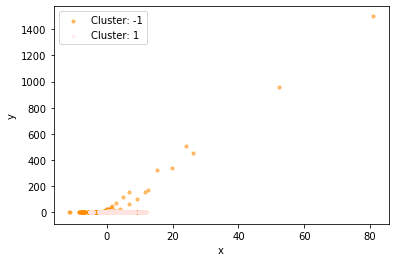

In [6]:
outliers_fraction=0.1
n_neighbors=20
labels=clustering.lof_fit_predict(X,outliers_fraction,n_neighbors)

# save predictions kmeans
utils.save(labels,dataset_type+"_prediction_lof")

# dimensionality reduction
XR=preprocessing.get_pc(X,2)

# print results
clustering.clustering_print_results(df,labels,selected_features,XR,True,True,dataset_type+'_lof')

In [7]:
# get anomalies
df_anomalies_lof=clustering.lof_anomalies(df,labels)
df_anomalies_lof.sort_values(by=sort_anomalies,ascending=False)

# save anomalies
utils.save(df_anomalies_lof,dataset_type+"_df_anomalies_lof")
df_anomalies_lof.to_csv("../outputs/"+dataset_type+"_df_anomalies_lof"+".csv")

# OCSVM

Variability explained by the PC: 0.40361135838123563

Exporting FLOW_OCSVM...
Number of clusters: 2

Cluster -1: 74556 data points

Cluster 1: 782278 data points

DONE.
-------------------------------------------------------


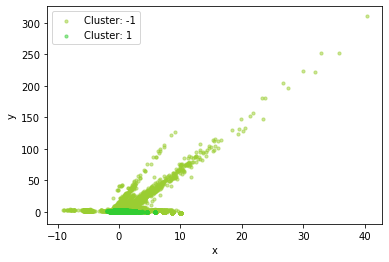

In [4]:
# train and test the model
outliers_fraction=cconfig.DEAFULT_CONTAMINATION
labels=clustering.ocsvm_fit_predict(X_Normal,X_Attack,outliers_fraction)
utils.save(labels,dataset_type+"_prediction_ocsvm")

# dimensionality reduction
XR=preprocessing.get_pc(X_Attack,2)

# print results
clustering.clustering_print_results(df_Attack,labels,selected_features,XR,True,True,dataset_type+'_ocsvm')

In [5]:
# get anomalies
df_anomalies_ocsvm=clustering.ocsvm_anomalies(df_Attack,labels)
df_anomalies_ocsvm.sort_values(by=sort_anomalies,ascending=False)
# save anomalies
utils.save(df_anomalies_ocsvm,dataset_type+"_df_anomalies_ocsvm")
df_anomalies_ocsvm.to_csv("../outputs/"+dataset_type+"_df_anomalies_ocsvm"+".csv")